In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import time
import datetime
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import sklearn
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


In [2]:
df = pd.read_csv("https://media.githubusercontent.com/media/TonyVideogame06/Haptic-Project-ArcheryGame-Panamerican-University/main/Estrategias_Proyecto/fraudTrain.csv", header=0, encoding='unicode_escape')

In [3]:
num_rows = df.shape[0]
print("Número de filas en el DataFrame:", num_rows)

Número de filas en el DataFrame: 1296675


In [4]:
#Distribucion 40-60
# Counting the instances of each class in the 'is_fraud' column
class_counts = df['is_fraud'].value_counts()

# Finding the minority and majority class
majority_class = class_counts.idxmax()
minority_class = class_counts.idxmin()

# Separating the majority and minority class instances
df_majority = df[df['is_fraud'] == majority_class]
df_minority = df[df['is_fraud'] == minority_class]

# Over-sampling the minority class to match the majority class count (40% created data)
df_minority_oversampled = df_minority.sample(int(class_counts[majority_class] * 0.4), replace=True, random_state=42)

# Combining the original majority class with the oversampled minority class (60% original data)
df = pd.concat([df_majority, df_minority_oversampled], axis=0)

# Shuffling the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Displaying some information about the modified dataset
df['is_fraud'].value_counts(), df.head()

(0    1289169
 1     515667
 Name: is_fraud, dtype: int64,
    Unnamed: 0 trans_date_trans_time            cc_num  \
 0      804910   2019-12-05 16:50:21  3591919803438423   
 1      539532   2019-08-19 09:30:39  3526826139003047   
 2      405724   2019-07-03 01:50:12  3508104404056005   
 3      197500   2019-04-12 03:08:26     4917226033950   
 4      945531   2020-01-13 00:54:13   349612764943496   
 
                         merchant       category     amt    first      last  \
 0              fraud_Larson-Moen  entertainment  170.06    Brian  Williams   
 1              fraud_Schmitt Inc  gas_transport   76.92   Nathan    Massey   
 2  fraud_Lockman, West and Runte    grocery_pos  268.73  Michael    Fisher   
 3          fraud_Deckow-O'Conner    grocery_pos  345.91     Adam    Keller   
 4                 fraud_Wolf Inc    grocery_pos  290.95   Xavier   Beltran   
 
   gender                       street  ...      lat     long  city_pop  \
 0      M  32941 Krystal Mill Apt. 552  

In [5]:
df['trans_date_trans_time'] = df['trans_date_trans_time'].astype('datetime64[ns]')
df = df.assign(trans_date = df['trans_date_trans_time'].dt.strftime("%d/%m/20%y"))
df = df.assign(trans_time = df['trans_date_trans_time'].dt.strftime("%H:%M:%S"))
df = df.drop(['cc_num'],axis=1)
df = df.drop(['first'],axis=1)
df = df.drop(['last'],axis=1)
df = df.drop(['gender'],axis=1)
df = df.drop(['city'],axis=1)
df = df.drop(['zip'],axis=1)
df = df.drop(['street'],axis=1)
df = df.drop(['job'],axis=1)
df = df.drop(['dob'],axis=1)
df = df.drop(['trans_num'],axis=1)
df = df.drop(['unix_time'],axis=1)
df = df.drop(['merch_lat'],axis=1)
df = df.drop(['merch_long'],axis=1)
df = df.drop(['trans_date_trans_time'],axis=1)

In [6]:
df = df.drop(['merchant'],axis=1)
df.head()

,Unnamed: 0,category,amt,state,lat,long,city_pop,is_fraud,trans_date,trans_time
0,804910,entertainment,170.06,FL,28.5697,-80.8191,54767,0,05/12/2019,16:50:21
1,539532,gas_transport,76.92,MI,44.2529,-85.0170,1126,0,19/08/2019,09:30:39
2,405724,grocery_pos,268.73,WI,42.8035,-88.4092,9679,1,03/07/2019,01:50:12
3,197500,grocery_pos,345.91,AL,32.2844,-86.9920,800,1,12/04/2019,03:08:26
4,945531,grocery_pos,290.95,KY,37.1046,-83.5706,467,1,13/01/2020,00:54:13


In [7]:
df = df.drop(['Unnamed: 0'],axis=1)
df.head()


,category,amt,state,lat,long,city_pop,is_fraud,trans_date,trans_time
0,entertainment,170.06,FL,28.5697,-80.8191,54767,0,05/12/2019,16:50:21
1,gas_transport,76.92,MI,44.2529,-85.0170,1126,0,19/08/2019,09:30:39
2,grocery_pos,268.73,WI,42.8035,-88.4092,9679,1,03/07/2019,01:50:12
3,grocery_pos,345.91,AL,32.2844,-86.9920,800,1,12/04/2019,03:08:26
4,grocery_pos,290.95,KY,37.1046,-83.5706,467,1,13/01/2020,00:54:13


In [8]:
# Convertir la columna 'trans_time' a tipo datetime.time y luego a un string para manipularla más fácilmente
df['trans_time'] = pd.to_datetime(df['trans_time'], format='%H:%M:%S').dt.time.astype(str)

# Redondear los minutos a la hora más cercana (eliminando los minutos y segundos)
df['trans_time_rounded'] = df['trans_time'].str[:2] + ':00'

In [9]:
df.head()

,category,amt,state,lat,long,city_pop,is_fraud,trans_date,trans_time,trans_time_rounded
0,entertainment,170.06,FL,28.5697,-80.8191,54767,0,05/12/2019,16:50:21,16:00
1,gas_transport,76.92,MI,44.2529,-85.0170,1126,0,19/08/2019,09:30:39,09:00
2,grocery_pos,268.73,WI,42.8035,-88.4092,9679,1,03/07/2019,01:50:12,01:00
3,grocery_pos,345.91,AL,32.2844,-86.9920,800,1,12/04/2019,03:08:26,03:00
4,grocery_pos,290.95,KY,37.1046,-83.5706,467,1,13/01/2020,00:54:13,00:00


<ipython-input-12-e25ad7bfb825>:19: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


ValueError: ignored

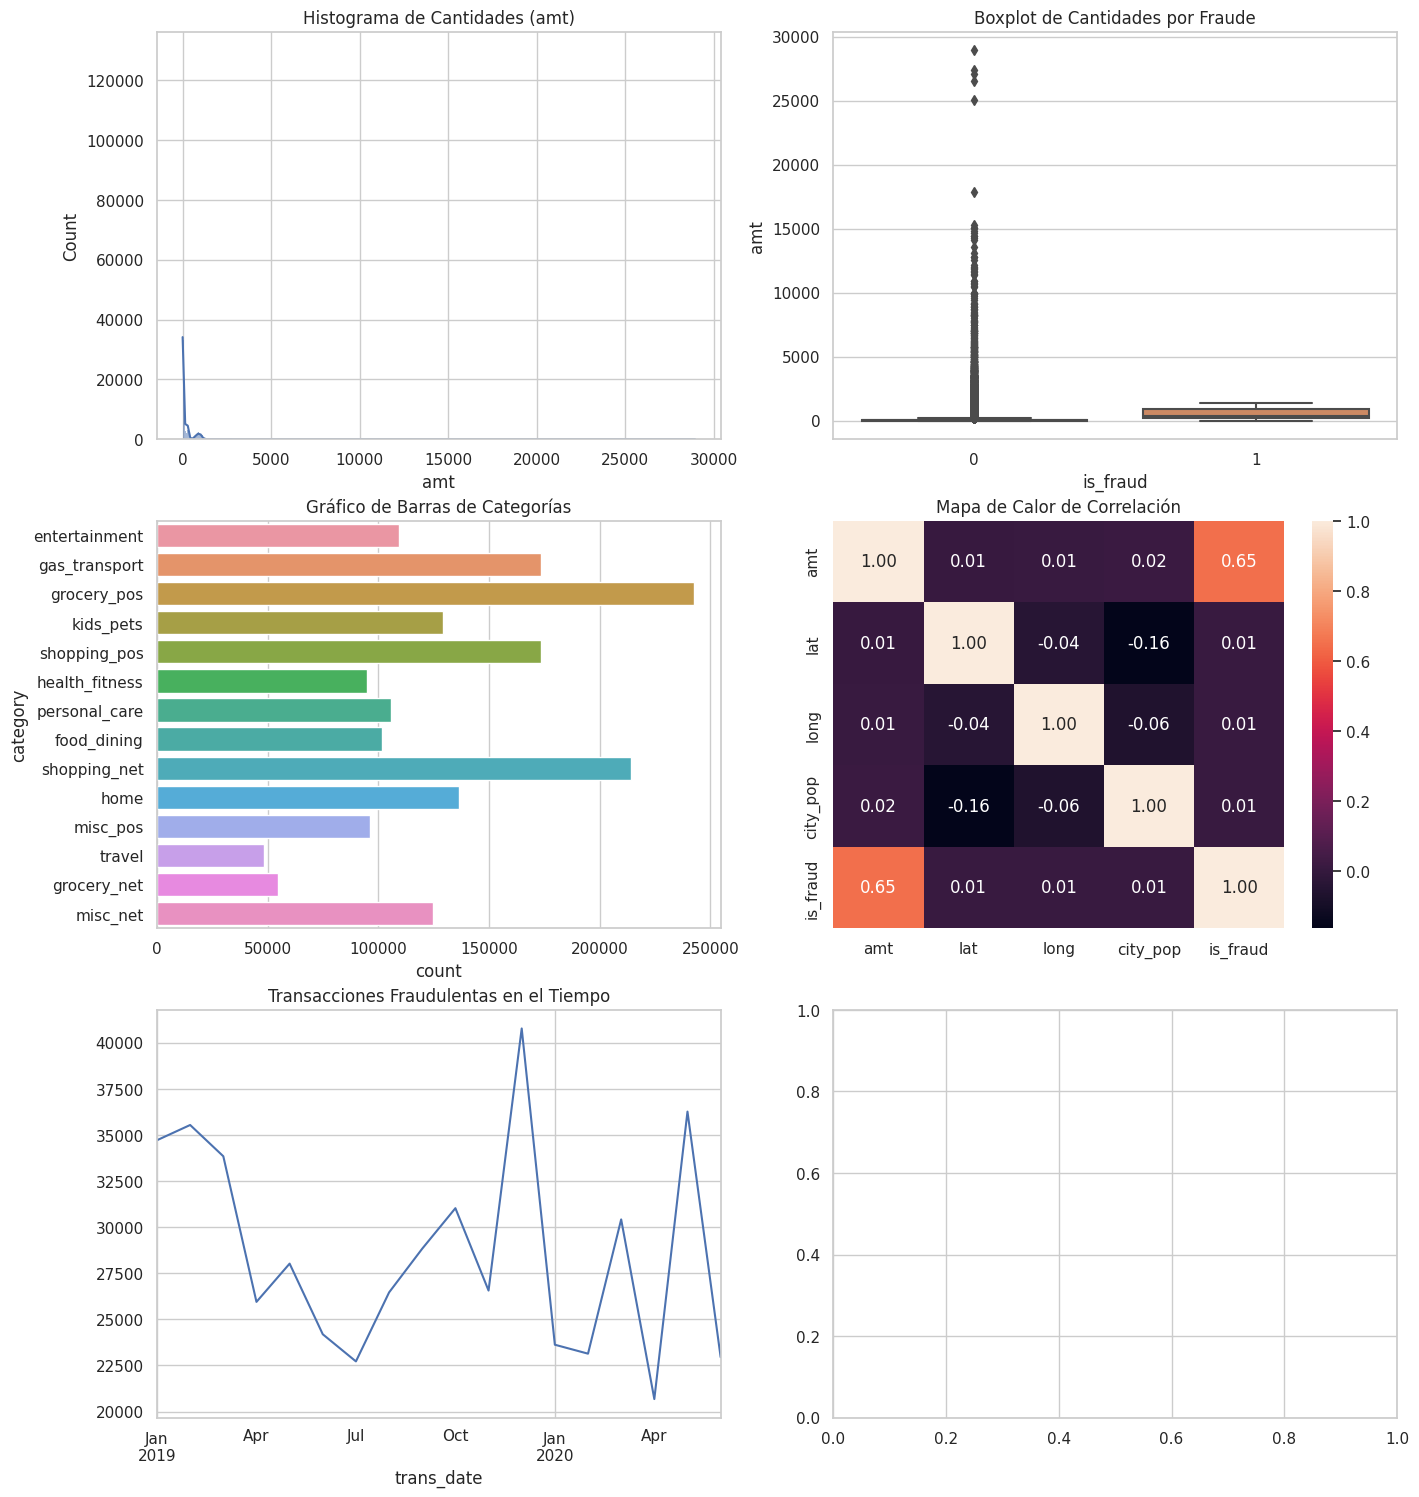

In [12]:
sns.set(style="whitegrid")

# Crear un contenedor de subplots para organizar las gráficas
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 18))

# Histograma de 'amt'
sns.histplot(df['amt'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Histograma de Cantidades (amt)')

# Boxplot de 'amt' por 'is_fraud'
sns.boxplot(x='is_fraud', y='amt', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Boxplot de Cantidades por Fraude')

# Gráfico de barras de 'category'
sns.countplot(data=df, y='category', ax=axes[1, 0])
axes[1, 0].set_title('Gráfico de Barras de Categorías')

# Mapa de calor de correlación
corr = df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", ax=axes[1, 1])
axes[1, 1].set_title('Mapa de Calor de Correlación')

# Gráfico de tiempo para transacciones fraudulentas
# Convertir 'trans_date' a tipo de dato datetime
df['trans_date'] = pd.to_datetime(df['trans_date'], format='%d/%m/%Y')
df_fraud = df[df['is_fraud'] == 1]
df_fraud.set_index('trans_date').resample('M').size().plot(ax=axes[2, 0])
axes[2, 0].set_title('Transacciones Fraudulentas en el Tiempo')

df['trans_time_rounded'] = pd.to_datetime(df['trans_time_rounded'], format='%H:%M:%S')
df_fraud = df[df['is_fraud'] == 1]
df_fraud.set_index('trans_time_rounded').resample('M').size().plot(ax=axes[2, 0])
axes[2, 0].set_title('Transacciones Fraudulentas en el Tiempo')
# Ocultar el último subplot vacío
axes[2, 1].axis('off')

# Ajustar el layout para evitar la superposición
plt.tight_layout()

# Mostrar las gráficas
plt.show()

In [13]:
#g = sns.FacetGrid(df, col='category', col_wrap=4, hue='is_fraud', sharex=False)
#.map_dataframe(sns.histplot, x='amt', bins=20)
#g.add_legend()
#g.set_titles(col_template="{col_name} (amt)")
#plt.suptitle('FacetGrid de Cantidades por Categoría y Fraude', y=1.02)
#lt.show()


In [10]:
# Convertir la columna 'trans_date' a tipo datetime
df['trans_date'] = pd.to_datetime(df['trans_date'], format='%d/%m/%Y')

# Descomponer la columna 'trans_date' en componentes temporales
df['year'] = df['trans_date'].dt.year
df['month'] = df['trans_date'].dt.month
df['day'] = df['trans_date'].dt.day
df['weekday'] = df['trans_date'].dt.weekday


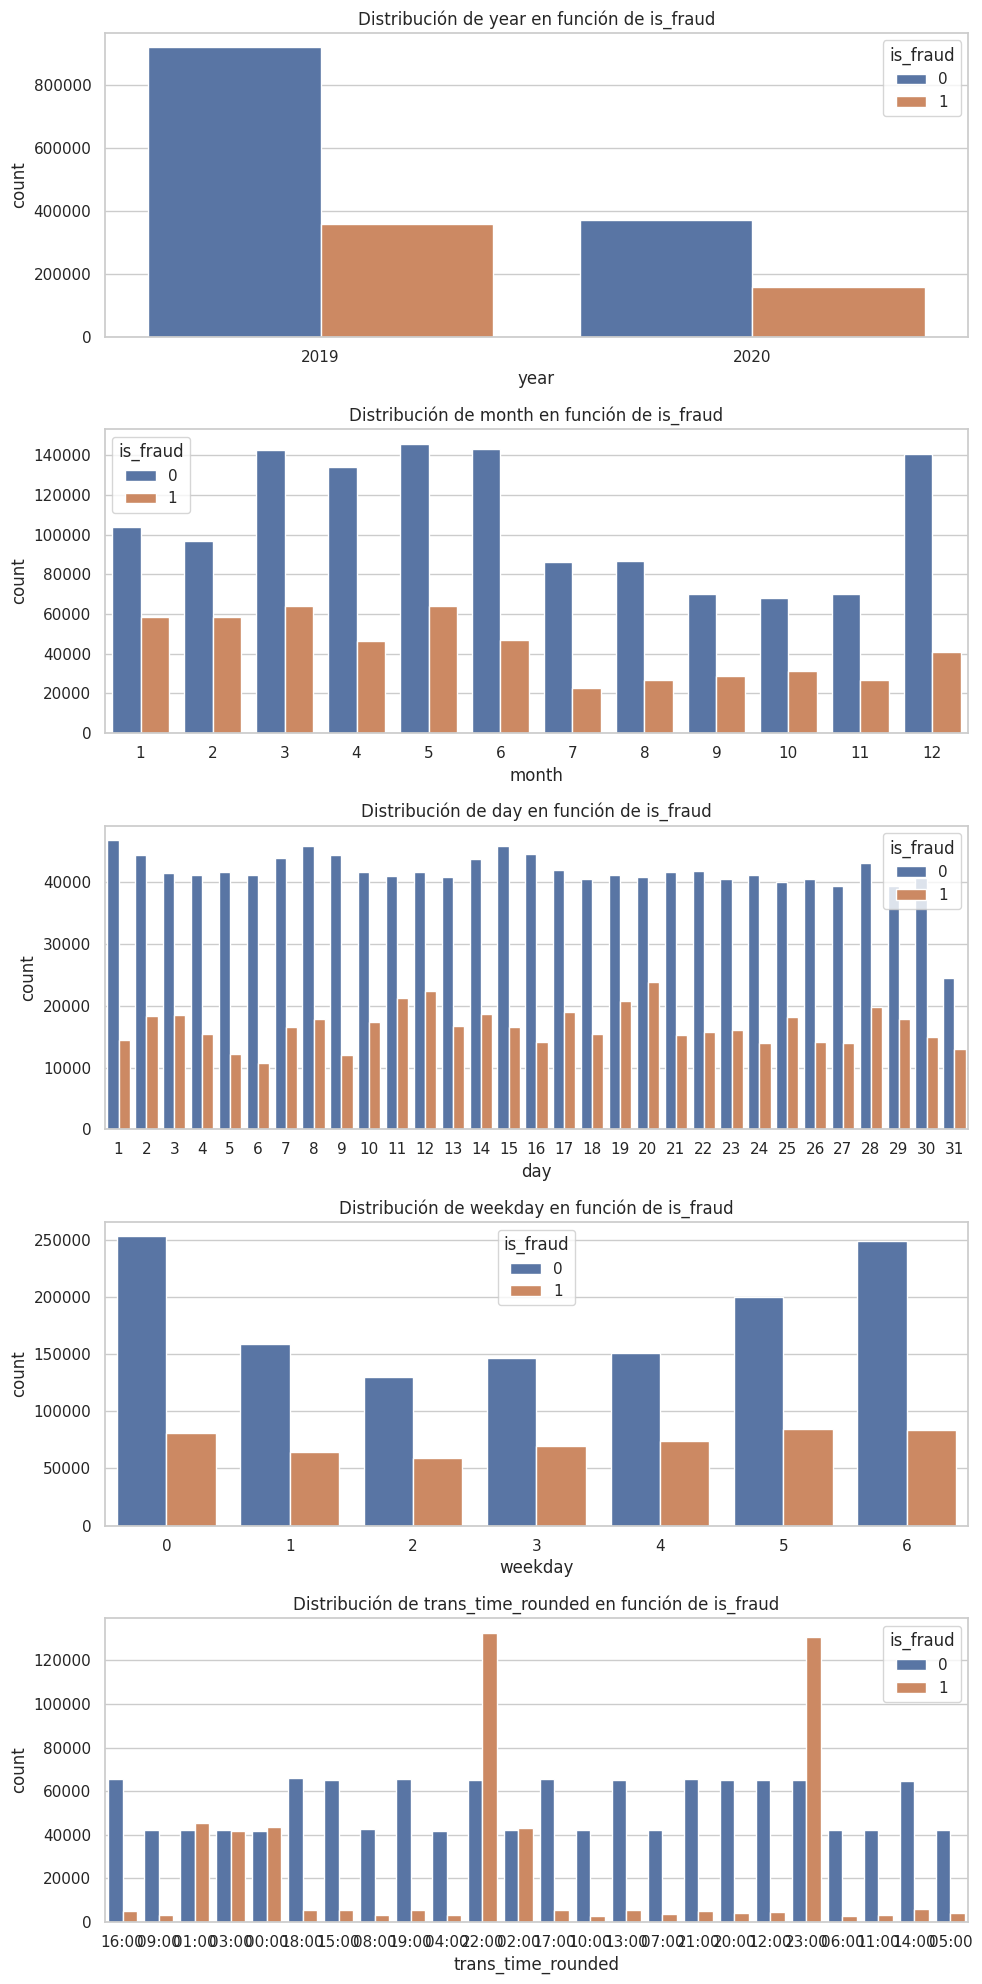

In [15]:
time_related_vars = ['year', 'month', 'day', 'weekday', 'trans_time_rounded']
fig, axes = plt.subplots(len(time_related_vars), 1, figsize=(10, 20))

for i, var in enumerate(time_related_vars):
    sns.countplot(data=df, x=var, hue='is_fraud', ax=axes[i])
    axes[i].set_title(f'Distribución de {var} en función de is_fraud')

plt.tight_layout()
plt.show()

In [16]:
# Guardar el DataFrame 'df' en un archivo CSV
df.to_csv('Fraud.csv', index=False)


KeyboardInterrupt: ignored

In [17]:
df.describe()

,amt,lat,long,city_pop,is_fraud,year,month,day,weekday
count,1.804836e+06,1.804836e+06,1.804836e+06,1.804836e+06,1.804836e+06,1.804836e+06,1.804836e+06,1.804836e+06,1.804836e+06
mean,2.001698e+02,3.857279e+01,-9.014188e+01,9.127490e+04,2.857140e-01,2.019292e+03,5.985827e+00,1.571009e+01,3.085298e+00
std,3.230763e+02,5.101930e+00,1.391018e+01,3.091228e+05,4.517540e-01,4.545779e-01,3.437238e+00,8.799996e+00,2.162017e+00
min,1.000000e+00,2.002710e+01,-1.656723e+02,2.300000e+01,0.000000e+00,2.019000e+03,1.000000e+00,1.000000e+00,0.000000e+00
25%,1.594000e+01,3.474370e+01,-9.678690e+01,7.430000e+02,0.000000e+00,2.019000e+03,3.000000e+00,8.000000e+00,1.000000e+00
50%,6.239000e+01,3.937640e+01,-8.734900e+01,2.501000e+03,0.000000e+00,2.019000e+03,5.000000e+00,1.600000e+01,3.000000e+00
75%,1.966300e+02,4.194880e+01,-8.012480e+01,2.047800e+04,1.000000e+00,2.020000e+03,9.000000e+00,2.300000e+01,5.000000e+00
max,2.894890e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.000000e+00,2.020000e+03,1.200000e+01,3.100000e+01,6.000000e+00


In [18]:
df.corr()

<ipython-input-18-2f6f6606aa2c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,amt,lat,long,city_pop,is_fraud,year,month,day,weekday
amt,1.000000,0.007467,0.013464,0.017876,0.648470,0.012352,-0.038342,0.012565,0.009863
lat,0.007467,1.000000,-0.040907,-0.163393,0.011127,0.000241,-0.013849,-0.015086,-0.004729
long,0.013464,-0.040907,1.000000,-0.063718,0.009806,-0.005602,0.006061,-0.004589,0.008045
city_pop,0.017876,-0.163393,-0.063718,1.000000,0.012786,0.002743,-0.005534,0.000019,0.008827
is_fraud,0.648470,0.011127,0.009806,0.012786,1.000000,0.017818,-0.073398,0.022407,0.010960
year,0.012352,0.000241,-0.005602,0.002743,0.017818,1.000000,-0.441621,-0.055799,-0.038827
month,-0.038342,-0.013849,0.006061,-0.005534,-0.073398,-0.441621,1.000000,0.013999,0.040910
day,0.012565,-0.015086,-0.004589,0.000019,0.022407,-0.055799,0.013999,1.000000,0.018047
weekday,0.009863,-0.004729,0.008045,0.008827,0.010960,-0.038827,0.040910,0.018047,1.000000


In [19]:
df.head()

,category,amt,state,lat,long,city_pop,is_fraud,trans_date,trans_time,trans_time_rounded,year,month,day,weekday
0,entertainment,170.06,FL,28.5697,-80.8191,54767,0,2019-12-05,16:50:21,16:00,2019,12,5,3
1,gas_transport,76.92,MI,44.2529,-85.0170,1126,0,2019-08-19,09:30:39,09:00,2019,8,19,0
2,grocery_pos,268.73,WI,42.8035,-88.4092,9679,1,2019-07-03,01:50:12,01:00,2019,7,3,2
3,grocery_pos,345.91,AL,32.2844,-86.9920,800,1,2019-04-12,03:08:26,03:00,2019,4,12,4
4,grocery_pos,290.95,KY,37.1046,-83.5706,467,1,2020-01-13,00:54:13,00:00,2020,1,13,0


In [11]:
df = df.drop(['year'],axis=1)

In [34]:
df_fraud = df[df['is_fraud'] == 1].head(100)
df_not_fraud = df[df['is_fraud'] == 0].head(100)

# Combinar los dos DataFrames
filtered_df_50_50 = pd.concat([df_fraud, df_not_fraud])

# Guardar el DataFrame de muestra en un archivo CSV
df_not_fraud.to_csv("sample_fraud_data.csv", index=False)

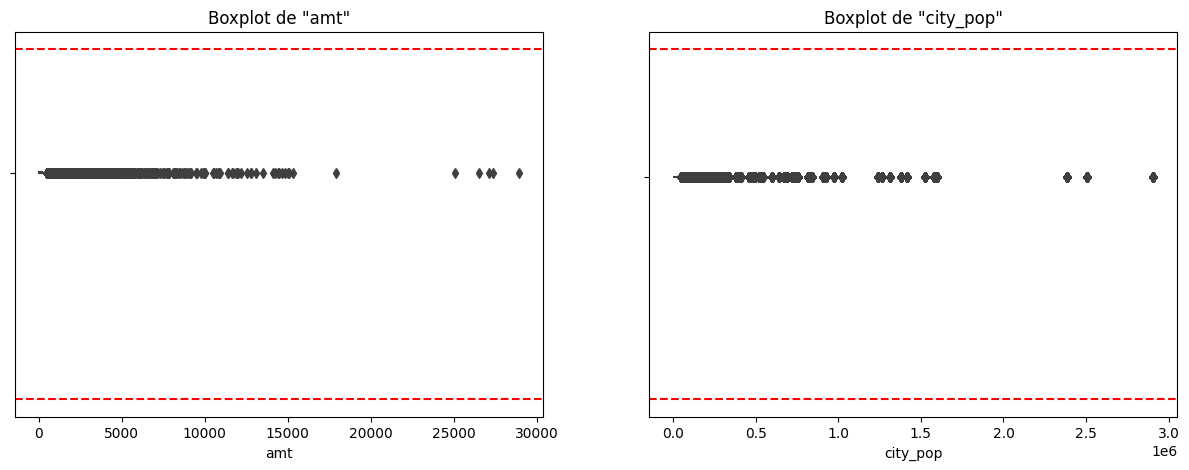

(-255.09499999999997, 467.66499999999996, 267437, -28859.5, 50080.5, 339907)

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Función para calcular el IQR y los límites para outliers
def calculate_iqr_limits(column_data):
    Q1 = column_data.quantile(0.25)
    Q3 = column_data.quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    return lower_limit, upper_limit

# Calcular los límites para detectar outliers en 'amt' y 'city_pop'
amt_lower_limit, amt_upper_limit = calculate_iqr_limits(df['amt'])
city_pop_lower_limit, city_pop_upper_limit = calculate_iqr_limits(df['city_pop'])

# Identificar los outliers
amt_outliers = df[(df['amt'] < amt_lower_limit) | (df['amt'] > amt_upper_limit)]
city_pop_outliers = df[(df['city_pop'] < city_pop_lower_limit) | (df['city_pop'] > city_pop_upper_limit)]

# Gráficos para visualizar los datos y los outliers
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(x=df['amt'], ax=axes[0])
axes[0].set_title('Boxplot de "amt"')
axes[0].axhline(y=amt_lower_limit, color='r', linestyle='--')
axes[0].axhline(y=amt_upper_limit, color='r', linestyle='--')

sns.boxplot(x=df['city_pop'], ax=axes[1])
axes[1].set_title('Boxplot de "city_pop"')
axes[1].axhline(y=city_pop_lower_limit, color='r', linestyle='--')
axes[1].axhline(y=city_pop_upper_limit, color='r', linestyle='--')

plt.show()

# Número de outliers identificados
num_amt_outliers = len(amt_outliers)
num_city_pop_outliers = len(city_pop_outliers)

amt_lower_limit, amt_upper_limit, num_amt_outliers, city_pop_lower_limit, city_pop_upper_limit, num_city_pop_outliers



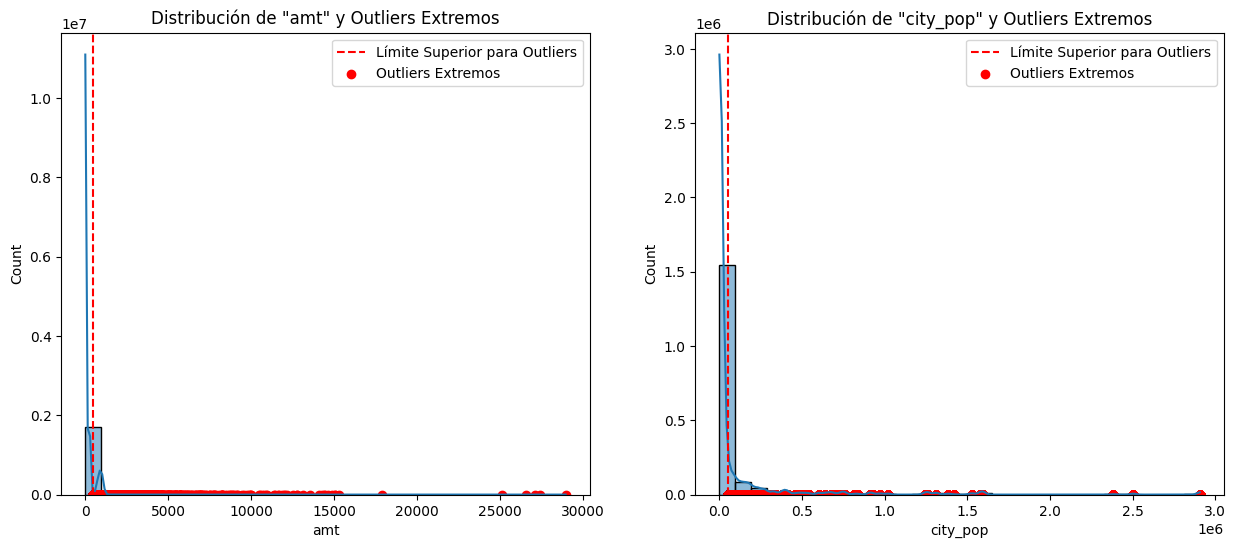

In [23]:
# Gráficos para visualizar la distribución de los datos y los outliers extremos
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico para 'amt'
sns.histplot(df['amt'], bins=30, kde=True, ax=axes[0])
axes[0].axvline(x=amt_upper_limit, color='r', linestyle='--', label='Límite Superior para Outliers')
axes[0].scatter(amt_extreme_outliers['amt'], [0]*len(amt_extreme_outliers), color='red', label='Outliers Extremos')
axes[0].set_title('Distribución de "amt" y Outliers Extremos')
axes[0].legend()

# Gráfico para 'city_pop'
sns.histplot(df['city_pop'], bins=30, kde=True, ax=axes[1])
axes[1].axvline(x=city_pop_upper_limit, color='r', linestyle='--', label='Límite Superior para Outliers')
axes[1].scatter(city_pop_extreme_outliers['city_pop'], [0]*len(city_pop_extreme_outliers), color='red', label='Outliers Extremos')
axes[1].set_title('Distribución de "city_pop" y Outliers Extremos')
axes[1].legend()

plt.show()


In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV

# Dividir los datos en conjuntos de entrenamiento y prueba
X = filtered_df.drop('is_fraud', axis=1)  # Variables independientes
y = filtered_df['is_fraud']  # Variable dependiente

# Dividir el dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir las columnas numéricas y categóricas
numeric_features = ['amt', 'city_pop', 'lat', 'long']
categorical_features = [ 'category','state','trans_time_rounded','month','day','weekday']


# Crear transformadores para variables numéricas y categóricas
numeric_transformer = StandardScaler()
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combinar transformadores en un preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Crear el modelo de Regresión Logística con el preprocesamiento
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LogisticRegression(random_state=42))])

# Parámetros para Grid Search
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
}

# Crear el modelo de Grid Search con validación cruzada
grid_search = GridSearchCV(model, param_grid, cv=5)

# Entrenar el modelo con Grid Search
grid_search.fit(X_train, y_train)

# Mostrar los mejores parámetros
print("Mejores parámetros: ", grid_search.best_params_)

# Realizar predicciones en el conjunto de prueba usando el mejor modelo encontrado
y_pred = grid_search.predict(X_test)


# Evaluar el rendimiento del modelo
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
#roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Mejores parámetros:  {'classifier__C': 0.001, 'classifier__penalty': 'l2'}
Accuracy: 0.9018484406829728
Precision: 0.9060471637677832
Recall: 0.731974064526209
F1 Score: 0.8097612090244733


In [30]:
y_train_pred = grid_search.predict(X_train)
accuracy_train = accuracy_score(y_train, y_train_pred)

#Evaluar el rendimiento en el conjunto de prueba
y_test_pred = grid_search.predict(X_test)
accuracy_test = accuracy_score(y_test, y_test_pred)

print(f"Accuracy en el conjunto de entrenamiento: {accuracy_train}")
print(f"Accuracy en el conjunto de prueba: {accuracy_test}")

Accuracy en el conjunto de entrenamiento: 0.9016029338817642
Accuracy en el conjunto de prueba: 0.9018484406829728


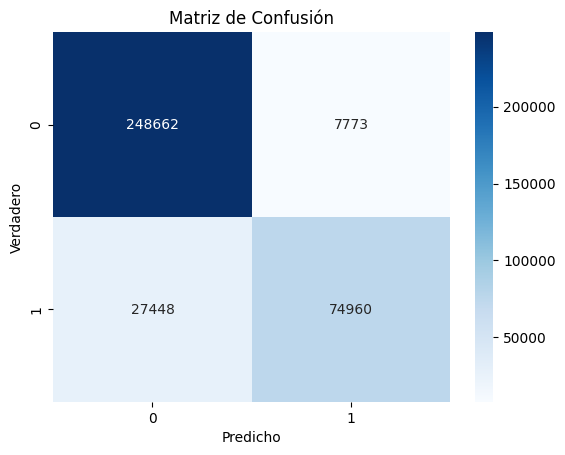

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicho')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión')
plt.show()


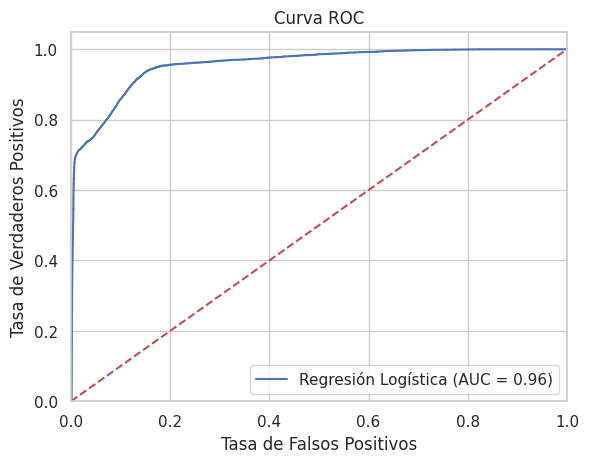

In [32]:
from sklearn.metrics import roc_curve, roc_auc_score

y_prob = grid_search.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure()
plt.plot(fpr, tpr, label=f'Regresión Logística (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()


In [27]:
import joblib

# Guardar el modelo en un archivo .pkl
joblib_file = "fraud_detection_model.pkl"
joblib.dump(grid_search, joblib_file)


['fraud_detection_model.pkl']

In [ ]:
# Importar las bibliotecas necesarias
import joblib
import pandas as pd

# Cargar el modelo desde el archivo .pkl
try:
    model = joblib.load('regresionlogistica.pkl')
    print("Modelo cargado con éxito.")
except Exception as e:
    print(f"Ocurrió un error al cargar el modelo: {e}")

# Crear un DataFrame de ejemplo para probar el modelo
# (asegúrate de usar los mismos nombres de columnas que en tu modelo original)
example_data = {
    'amt': [170.06],
    'city_pop': [54767],
    'lat': [28.5697],
    'long': [-80.8191],
    'category': ['entertainment	'],
    'state': ['FL'],
    'trans_date':['03/07/2019'],
    'trans_time':['01:50:12']
}

example_df = pd.DataFrame(example_data)

# Realizar una predicción con el modelo cargado
try:
    prediction = model.predict(example_df)
    print(f"Predicción realizada con éxito: {prediction}")
except Exception as e:
    print(f"Ocurrió un error al hacer la predicción: {e}")
